In [1]:
# Import Libraries
import numpy as np

from project_utils.bb_model         import BB_Model
from project_utils.feature_stats    import Feature_Statistics_C
from project_utils.feature_stats    import Regression_Container
from project_utils.acq_data_capture import Acq_Data_nD
from project_utils.surroagte_gp     import Surrogate_GP



In [2]:
Num_Points    = 6
Title         = 'Diabetes'
FUR_Weight    = 0.1
N_consistancy = 25
consist_bound = 0.3

In [3]:
if isinstance(FUR_Weight, float):
    FUR_Weight = [FUR_Weight, 1.0 - FUR_Weight]
    
print(FUR_Weight)

[0.1, 0.9]


In [4]:
Title = Title + ' W:'+ str(FUR_Weight)

In [5]:
# Load Forrester model

Class_data = BB_Model(dataset = 'Diabetes_2')
                      
#Class_data.df().head()

In [6]:
Class_data.MPL()

0.6168831168831169


MLPClassifier(random_state=RandomState(MT19937) at 0x1D03F9D9840)

In [7]:
Class_data.Random_Forest()

0.7207792207792207


RandomForestClassifier(random_state=RandomState(MT19937) at 0x1D03F9D9840)

In [8]:
#Class_data.GP()

In [9]:
Class_data.L_Regression()

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7272727272727273


LogisticRegression()

In [10]:
print(Class_data.get_features())

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [11]:
#Default settings
from unravel_2.ur_model import UR_Model

X_train, X_test, y_train, y_test = Class_data.get_TT_data()

#Initializing the explainer object
URM_Exp = UR_Model(bbox_model           = Class_data.get_Random_Forest(),
                   train_data           = X_train,
                   feature_names        = Class_data.get_features(),
                   categorical_features = Class_data.get_catagorical(),
                   mode                 = Class_data.get_mode(),
                   sampling_optimize    = "opt")

#sur_GP = Surrogate_GP()


In [12]:
#I2nd explainer object
URM_Exp_2 = UR_Model(bbox_model           = Class_data.get_L_Regression(),
                     train_data           = X_train,
                     feature_names        = Class_data.get_features(),
                     categorical_features = Class_data.get_catagorical(),
                     mode                 = Class_data.get_mode(),
                     sampling_optimize    = "opt")



In [13]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
print('Mean 0:', mean)
print('Std 0: ', std)


Mean 0: [  3.73941368 120.8029316   68.76384365  20.62703583  81.15309446
  31.81889251   0.48718567  33.10749186]
Std 0:  [  3.34018719  31.66994781  19.58281327  16.04216711 117.60701419
   7.8748146    0.3410962   11.88756402]


In [14]:
# Generate explantion data for Random Forest

Class_Stats   = Feature_Statistics_C(feature_names = Class_data.get_features(),
                                     mode          = Class_data.get_mode(),
                                     classes       = Class_data.get_classes(),
                                     X_train_std   = Class_data.get_X_train_std(),
                                     N_consistancy = N_consistancy)

Class_Stats_2 = Feature_Statistics_C(feature_names = Class_data.get_features(),
                                     mode          = Class_data.get_mode(),
                                     classes       = Class_data.get_classes(),
                                     X_train_std   = Class_data.get_X_train_std())


if Num_Points > X_test.shape[0]: Num_Points = X_test.shape[0]

elif Num_Points == 0:            Num_Points = X_test.shape[0]

for test_instance in range(Num_Points):

    print('INSTANCE: ', test_instance)
       
    data_row  = np.array([X_test[test_instance]])
    
#    data_row  = np.array([0.4])

#    print('data row ',data_row)
    
    URM_Exp.explain(X_init      = data_row.reshape(1, -1),
                    Dimension   = 'Multi D',
                    kernel_type = "Matern_3",
                    max_iter    = 20,
                    alpha       = "FUR_W",
                    #jitter=5,
                    interval    = 1,
                    weight      = FUR_Weight)
       
    f_predict = Class_data.get_Random_Forest().predict_proba(data_row.reshape(1, -1))

    e_predict = URM_Exp.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    acq_data = URM_Exp.get_acq_data()
    
#    X, y = URM_Exp.get_surrogate_data()

#    e_predict = sur_GP.predict(X, y)
#    e_predict = sur_GP.predict(URM_Exp.get_surrogate_data())

#    print(f_predict, e_predict, acq_data.get_fe_x0())
    
    scores = URM_Exp.permutation_importance()
    
    consistancy = URM_Exp.Y_Consistancy(N_points = N_consistancy, std_bound = consist_bound)
    
    URM_Exp.del_1_rel()
    
    del_1_var = URM_Exp.get_del_1_variance()
    
    Class_Stats.Add_Sample(sample_scores = scores,
                         outcome       = y_test[test_instance],
                         X_row         = data_row.reshape(1, -1),
                         f_prediction  = f_predict,
                         e_prediction  = e_predict.ravel(),
                         feopt         = acq_data.get_fe_x0(),
                         consistancy   = consistancy,
                         del_1_var     = del_1_var)
    
    
    ############################################################################################
    
    URM_Exp_2.explain(X_init      = data_row.reshape(1, -1),
                      Dimension   = 'Multi D',
                      kernel_type = "Matern_3",
                      max_iter    = 20,
                      alpha       = "FUR_W",
                      #jitter=5,
                      interval    = 1,
                      weight      = FUR_Weight)
       
    f_predict = Class_data.get_L_Regression().predict_proba(data_row.reshape(1, -1))

    e_predict = URM_Exp_2.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    scores = URM_Exp_2.permutation_importance()
    
    Class_Stats_2.Add_Sample(sample_scores = scores,
                           outcome       = y_test[test_instance],
                           X_row         = data_row.reshape(1, -1),
                           f_prediction  = f_predict,
                           e_prediction  = e_predict.ravel(),
                           feopt         = None)
    


INSTANCE:  0
Acq_Data_nD
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

ADD ----> [[0.99 0.01]] [0.00000000e+00 2.18229528e-06]
Acq_Data_nD
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and cal

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and cal

Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and cal

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

ADD ----> [[0.99863403 0.00136597]] [0.0000000e+00 2.1822444e-06]
INSTANCE:  1
Acq_Data_nD
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and cal

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 7 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and cal

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and cal

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and cal

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and cal

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and cal

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and cal

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 7 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and cal

ADD ----> [[0.97 0.03]] [-1.62295501e-08  9.99922878e-06]
Acq_Data_nD
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and cal

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and cal

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 7 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and cal

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

ADD ----> [[0.91617083 0.08382917]] [1.18672446e-14 9.99999486e-06]
INSTANCE:  2
Acq_Data_nD
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

ADD ----> [[0.93 0.07]] [0.00000000e+00 2.18242246e-06]
Acq_Data_nD
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 7 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 7 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 7 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

ADD ----> [[0.91621741 0.08378259]] [7.82908952e-14 9.99999486e-06]
INSTANCE:  3
Acq_Data_nD
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 7 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 7 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 7 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 7 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 7 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 7 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

ADD ----> [[0.59 0.41]] [1.20477983e-09 1.00000004e-05]
Acq_Data_nD
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

ADD ----> [[0.60618851 0.39381149]] [1.89481493e-08 9.99949525e-06]
INSTANCE:  4
Acq_Data_nD
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 7 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

ADD ----> [[0.95 0.05]] [6.28205666e-12 1.00000004e-05]
Acq_Data_nD
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and cal

ADD ----> [[0.88035023 0.11964977]] [0.00000000e+00 2.18237159e-06]
INSTANCE:  5
Acq_Data_nD
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and cal

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and cal

ADD ----> [[0.29 0.71]] [1.00000000e+00 1.00000004e-05]
Acq_Data_nD
Matern 3 --------------->
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 7 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->
Matern 3 --------------->
Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


ADD ----> [[0.37734746 0.62265254]] [9.99999998e-01 9.99987274e-06]


In [15]:
import matplotlib.pyplot as plt


In [16]:
print(f_predict)
print(e_predict)


[[0.37734746 0.62265254]]
[9.99999998e-01 9.99987274e-06]


In [17]:
Class_Stats.Feature_Counts(max_features=20, scaled=True, threshold=0.05)


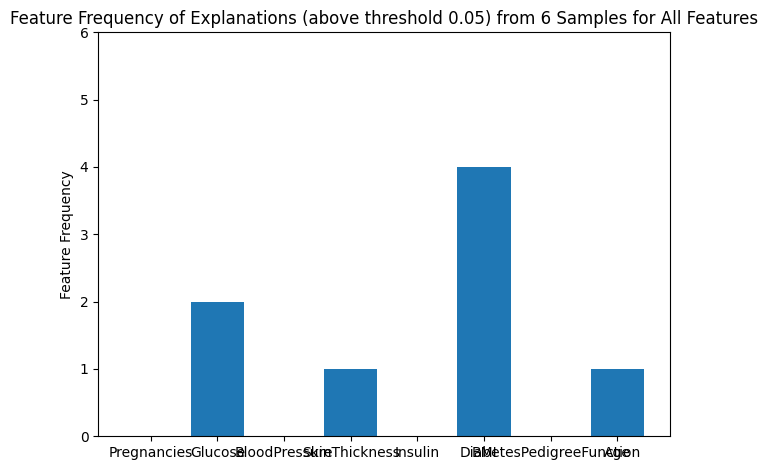

In [18]:
Class_Stats.Frequency_Plot()


In [19]:
Class_Stats.Class_Fidelity()

F and E Predictions All [[0.99 0.01]
 [0.97 0.03]
 [0.93 0.07]
 [0.59 0.41]
 [0.95 0.05]
 [0.29 0.71]] [[ 0.00000000e+00  2.18229528e-06]
 [-1.62295501e-08  9.99922878e-06]
 [ 0.00000000e+00  2.18242246e-06]
 [ 1.20477983e-09  1.00000004e-05]
 [ 6.28205666e-12  1.00000004e-05]
 [ 1.00000000e+00  1.00000004e-05]]
F and E Predictions [0.01 0.03 0.07 0.41 0.05 0.71] [2.18229528e-06 9.99922878e-06 2.18242246e-06 1.00000004e-05
 1.00000004e-05 1.00000004e-05]
F and E Outcomes [0 0 0 0 0 1] [1 1 1 1 1 0]
BB(x) - exp(x) proba dif  Avg:  0.5349963042541409  var:  0.14887692787538098  max:  0.99
Scores:
BB Model Score:   0.6666666666666666
Exp Model Score:  0.3333333333333333
BB - Exp Score:   0.0
Fidelity:  0.465
Accuracy Score:           0.0
Balanced Accuracy Score:  0.0


In [20]:
Class_Stats.Jaccard_Values()

Mean Jaccard Similarity:  0.4746031746031747
Mean Jaccard Distance:    0.5253968253968253


top_features True
top_features (6, 8)


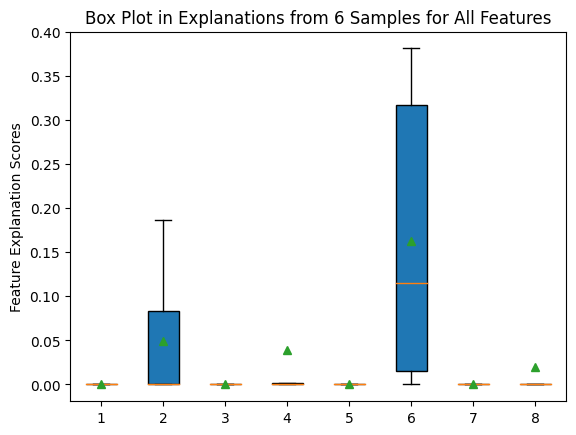

1 -      Pregnancies
2 -      Glucose
3 -      BloodPressure
4 -      SkinThickness
5 -      Insulin
6 -      BMI
7 -      DiabetesPedigreeFunction
8 -      Age


In [21]:
Class_Stats.Box_Plot()


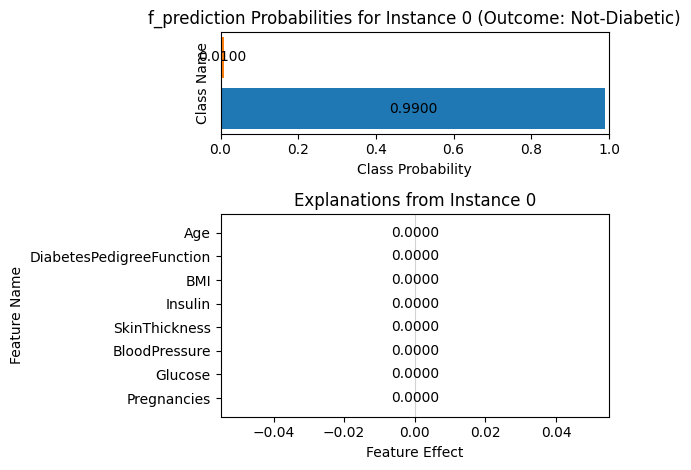

In [22]:
Class_Stats.View_Explanation(instance = 0)

In [23]:
scores = URM_Exp.permutation_importance()
    
print(scores)

[-4.37717626e-23  2.68301785e-20  1.07294453e-20  5.92790169e-21
  3.96604024e-19  3.99999998e-01  2.59926947e-21  1.03156070e-20]


In [24]:
scores_k = URM_Exp.KL_imp()

print(scores_k)

[6.75226526e-07 7.09025443e-07 6.23902189e-07 6.36354285e-07
 7.69908947e-07 1.99103420e+00 3.33859758e-06 7.15556527e-07]


In [25]:
scores_v = URM_Exp.Var_imp()

print(scores_v)

[3.70074342e-17 7.40148685e-17 1.00448750e-16 6.34413157e-17
 5.28677736e-17 1.96629138e-01 1.32169409e-16 7.40148684e-17]


In [26]:
scores_d1 = URM_Exp.del_1_rel()

print(scores_d1)

[1.81898893e-12 4.00337436e-11 1.36459697e-11 0.00000000e+00
 0.00000000e+00 8.00000000e+00 0.00000000e+00 1.27338107e-11]


In [27]:
scores_d2 = URM_Exp.del_2_rel()

print(scores_d2)

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and cal

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and cal

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and cal

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Matern 3 --------------->


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

[4.30065132e-04 1.95773849e+00 9.72753868e-05 4.22556567e-04
 4.16794797e-04 5.57039808e+00 4.34529455e-04 4.70062205e-01]


In [28]:
lin_scores = URM_Exp.Lin_scores()

print(lin_scores)

[-0.38764019  0.01131995  0.00198289 -0.01006133  0.01024919  0.08440963
  0.42406552 -0.01665537]


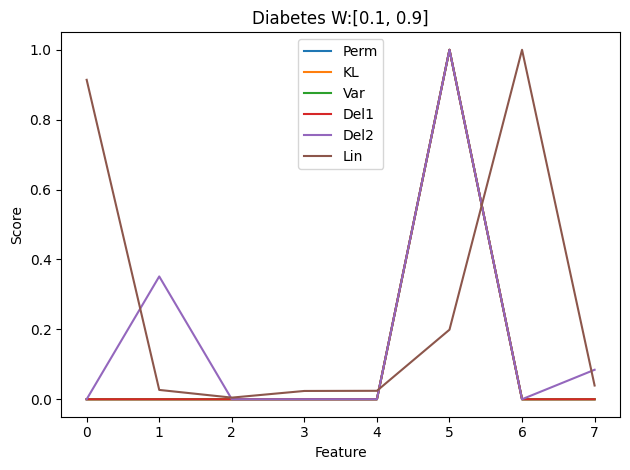

In [29]:
URM_Exp.plot_scores(Title)

In [30]:
print(URM_Exp.get_exp_L())


[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.88160813e-01  9.82138233e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.85343121e-01 -3.76100384e-02  9.22006596e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.0

In [31]:
acq_data.Create_BB_plot()

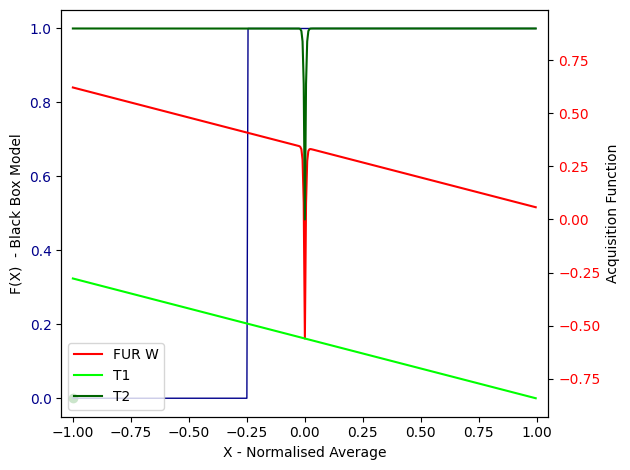

In [32]:
acq_data.plot_point(0)

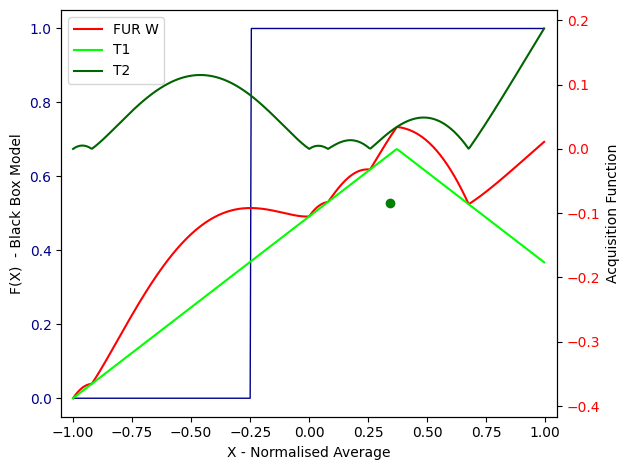

In [33]:
acq_data.plot_point(5)

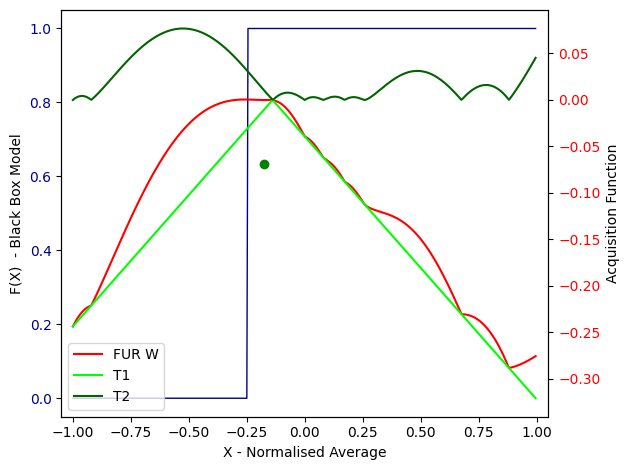

In [34]:
acq_data.plot_point(10)

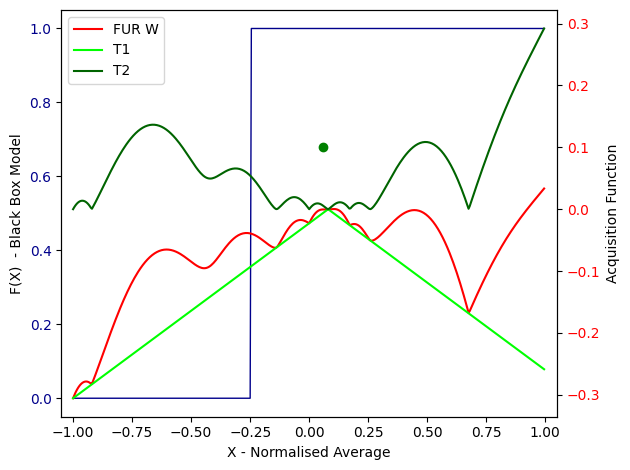

In [35]:
acq_data.plot_point(15)

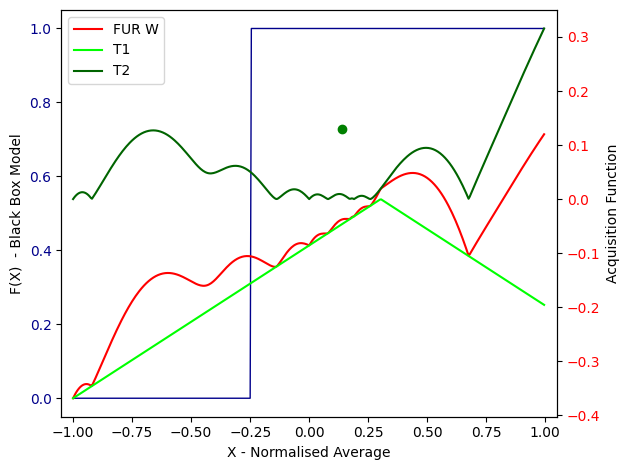

In [36]:
acq_data.plot_point(19)

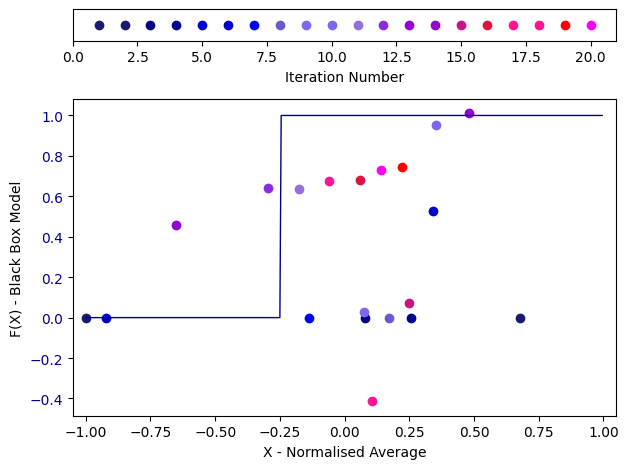

In [37]:
acq_data.plot_all()

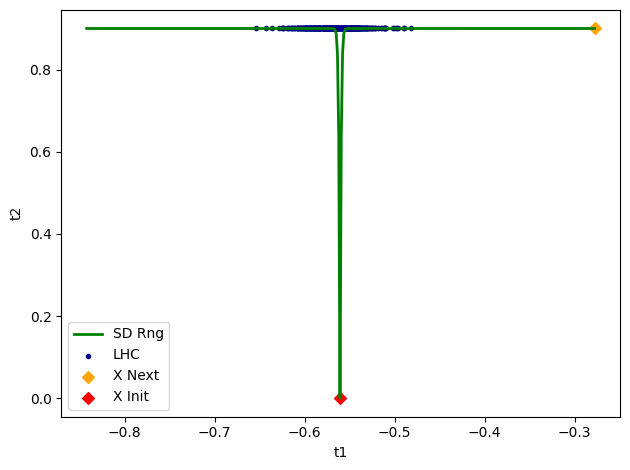

In [38]:
acq_data.plot_t1_t2(0)

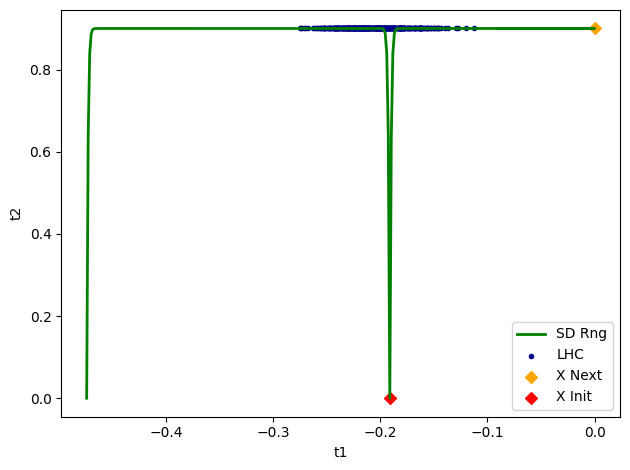

In [39]:
acq_data.plot_t1_t2(1)

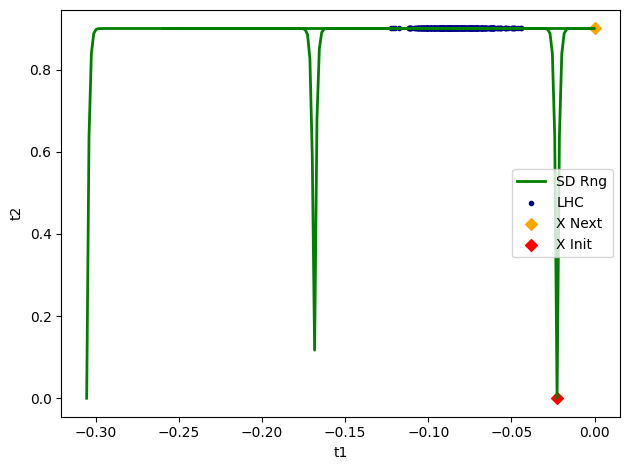

In [40]:
acq_data.plot_t1_t2(2)

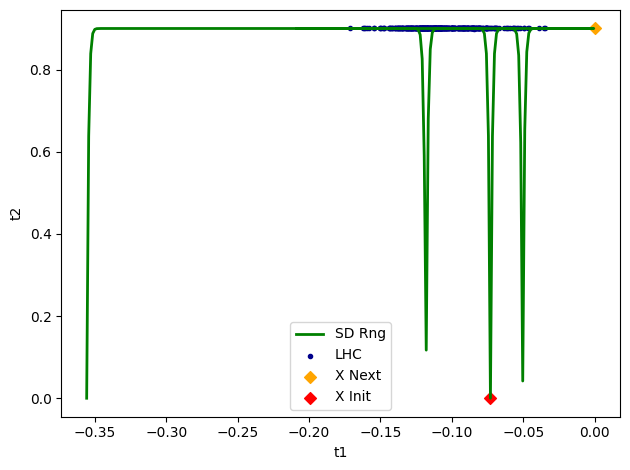

In [41]:
acq_data.plot_t1_t2(3)

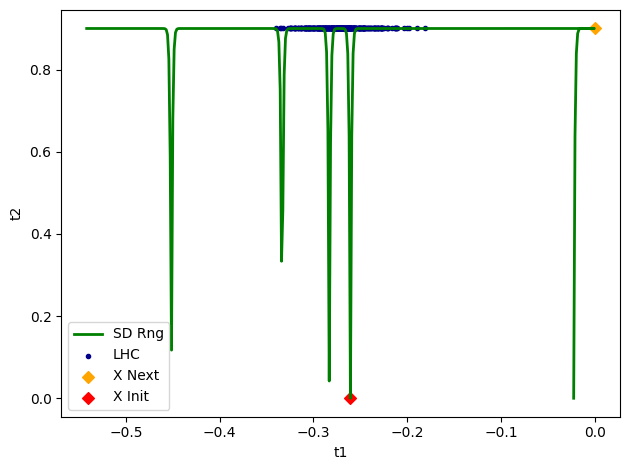

In [42]:
acq_data.plot_t1_t2(4)

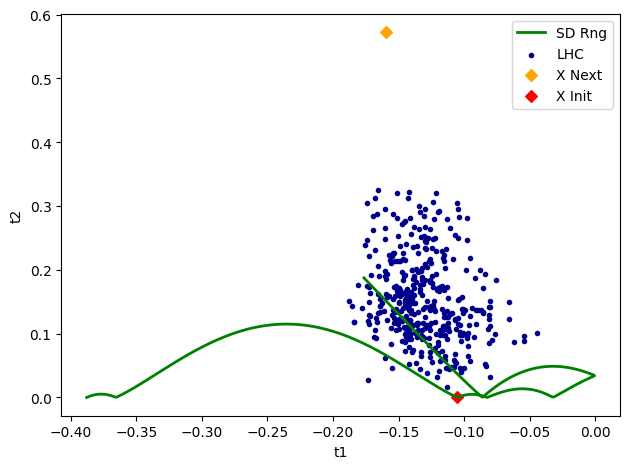

In [43]:
acq_data.plot_t1_t2(5)

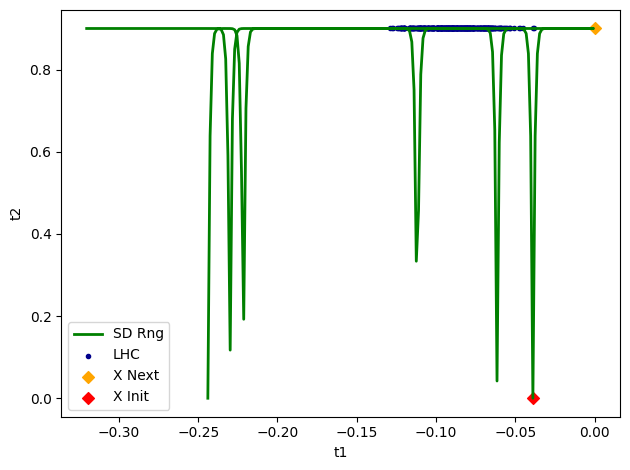

In [44]:
acq_data.plot_t1_t2(6)

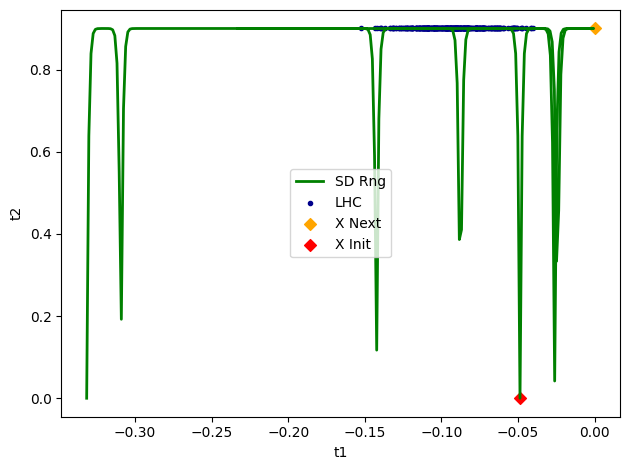

In [45]:
acq_data.plot_t1_t2(7)

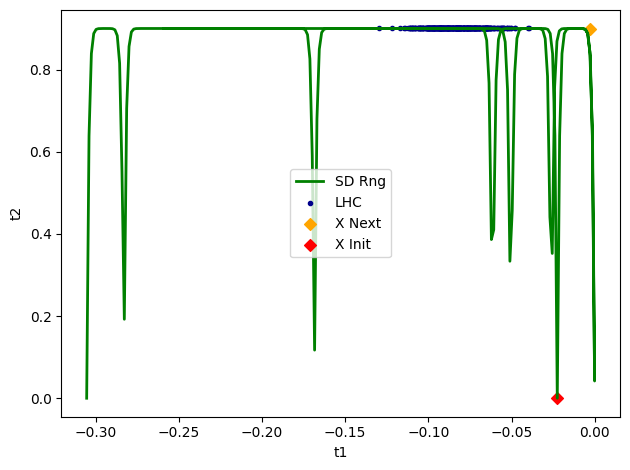

In [46]:
acq_data.plot_t1_t2(8)

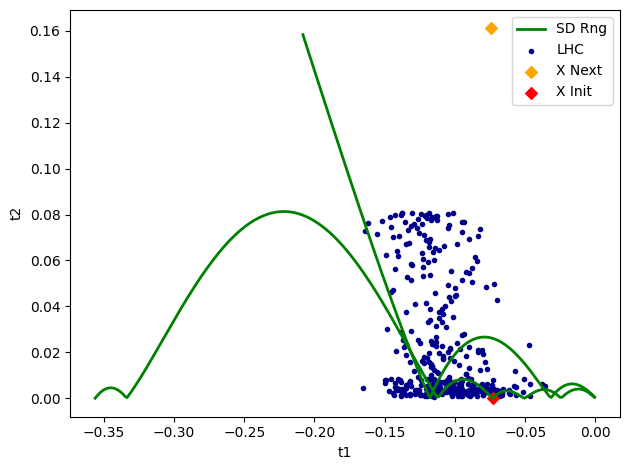

In [47]:
acq_data.plot_t1_t2(9)

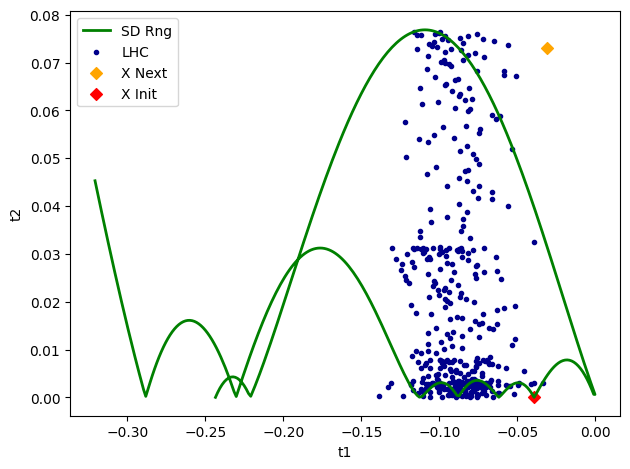

In [48]:
acq_data.plot_t1_t2(10)

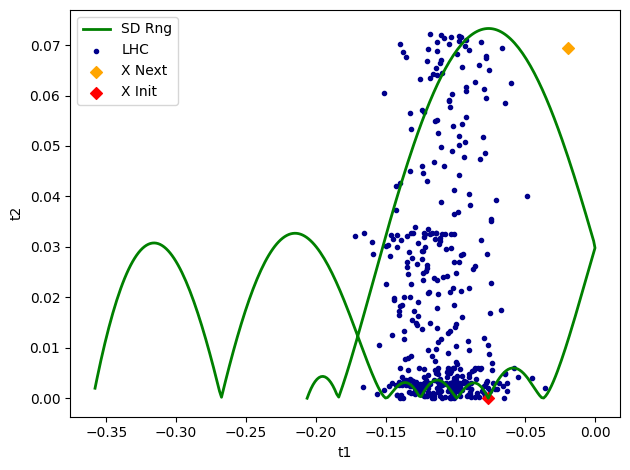

In [49]:
acq_data.plot_t1_t2(11)

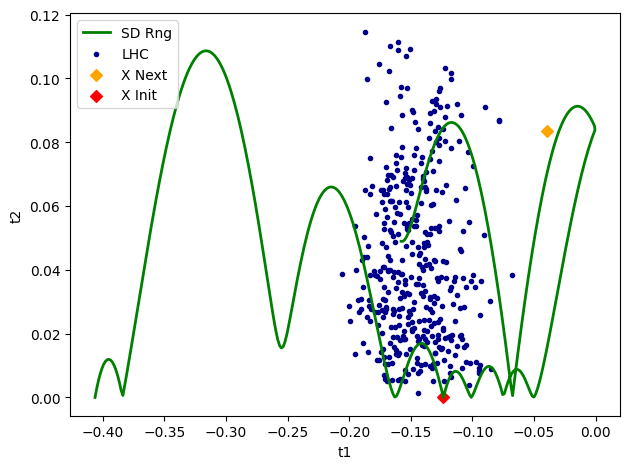

In [50]:
acq_data.plot_t1_t2(12)

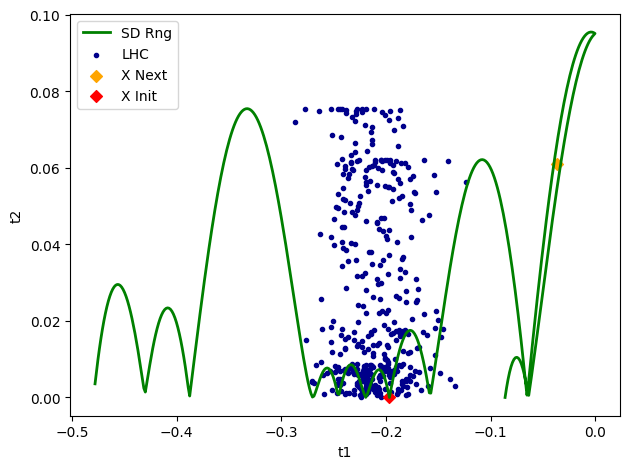

In [51]:
acq_data.plot_t1_t2(13)

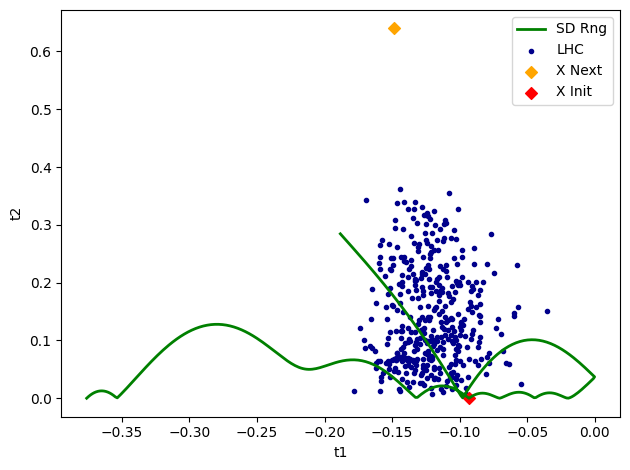

In [52]:
acq_data.plot_t1_t2(14)

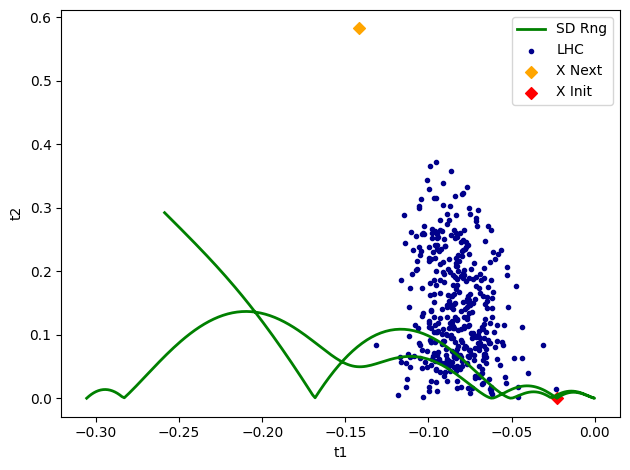

In [53]:
acq_data.plot_t1_t2(15)

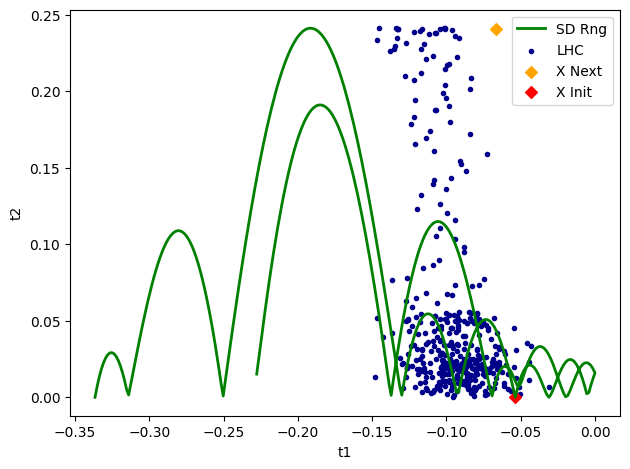

In [54]:
acq_data.plot_t1_t2(16)

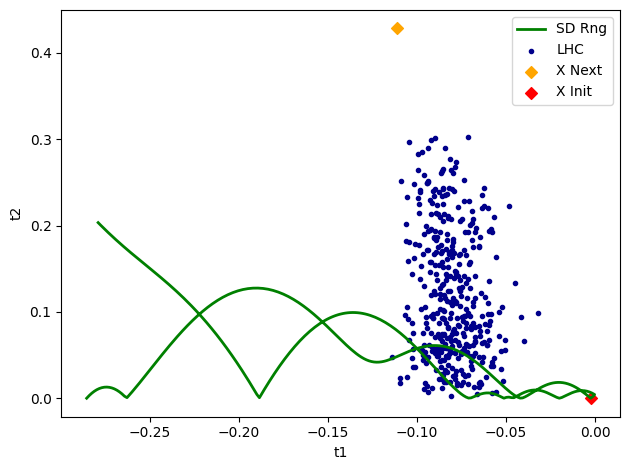

In [55]:
acq_data.plot_t1_t2(17)

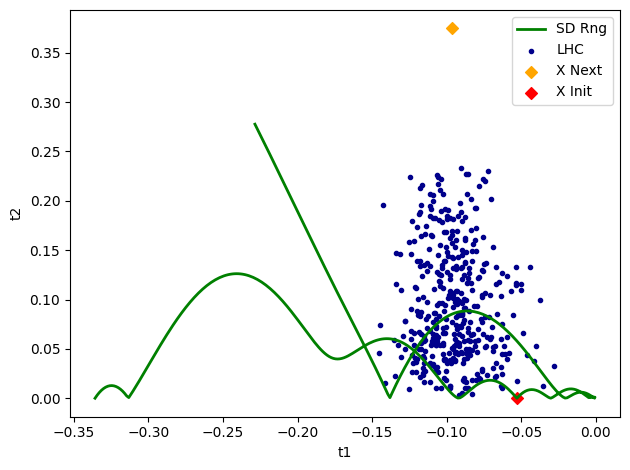

In [56]:
acq_data.plot_t1_t2(18)

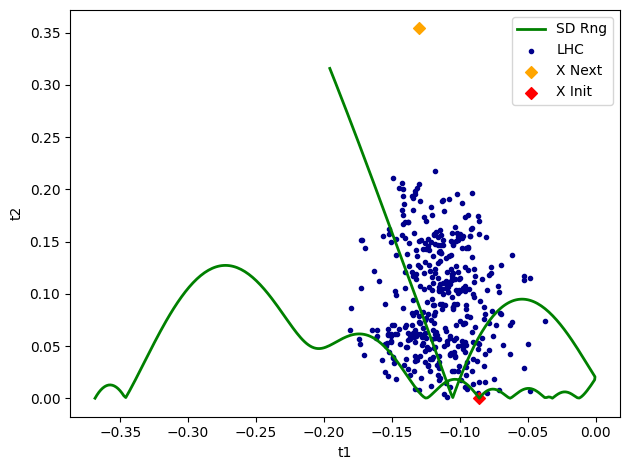

In [57]:
acq_data.plot_t1_t2(19)

In [58]:
Class_Stats.Class_Fidelity()

print('Fidelity: ', Class_Stats.fidelity)

F and E Predictions All [[0.99 0.01]
 [0.97 0.03]
 [0.93 0.07]
 [0.59 0.41]
 [0.95 0.05]
 [0.29 0.71]] [[ 0.00000000e+00  2.18229528e-06]
 [-1.62295501e-08  9.99922878e-06]
 [ 0.00000000e+00  2.18242246e-06]
 [ 1.20477983e-09  1.00000004e-05]
 [ 6.28205666e-12  1.00000004e-05]
 [ 1.00000000e+00  1.00000004e-05]]
F and E Predictions [0.01 0.03 0.07 0.41 0.05 0.71] [2.18229528e-06 9.99922878e-06 2.18242246e-06 1.00000004e-05
 1.00000004e-05 1.00000004e-05]
F and E Outcomes [0 0 0 0 0 1] [1 1 1 1 1 0]
BB(x) - exp(x) proba dif  Avg:  0.5349963042541409  var:  0.14887692787538098  max:  0.99
Scores:
BB Model Score:   0.6666666666666666
Exp Model Score:  0.3333333333333333
BB - Exp Score:   0.0
Fidelity:  0.465
Accuracy Score:           0.0
Balanced Accuracy Score:  0.0
Fidelity:  0.4650036957458591


In [59]:
Class_Stats.Jaccard_Values(top_k=4)

print('Jaccard: ', Class_Stats.jaccard_similarities)

Mean Jaccard Similarity:  0.398095238095238
Mean Jaccard Distance:    0.6019047619047619
Jaccard:  0.398095238095238


In [60]:
Class_Stats.Consistancy(std_bound = consist_bound, plot=True, title = Title)

Consistancey Std/P Pert:  0.3 : 0.017261939799544476
Perturbed Changes: 1.0 0.0 1.0 1.0


In [61]:
Class_Stats.Compare_Models (model_b = Class_Stats_2)

mean_scores:  [2.59199021e-22 4.94841552e-02 9.33904997e-18 3.87528597e-02
 2.94313581e-19 1.62954322e-01 3.75874514e-05 1.95303810e-02]
mean_scores_d:  [3.35611409e-02 9.44251706e-02 3.70059018e-19 3.87008688e-02
 3.74233116e-22 1.73071081e-02 3.82433964e-14 1.96382998e-04]
Score Diff Mean:  [-1.00000000e+00 -3.12287026e-01  9.23770756e-01  6.71250749e-04
  9.97460138e-01  8.07977690e-01  9.99999998e-01  9.80089689e-01]
Score Diff SD:    [2.23606798 1.33152117 2.16912385 1.50128578 1.96220217 0.78157058
 2.23606797 2.21836688]
 Model Feature Correlation:  0.21501688241049907


In [62]:
Class_Stats.Calibration()

Brier_Score:  0.1666633334014471


In [63]:
Class_Stats.delete_one()

mean_variance [1.26860004e-11 3.68323470e-02 7.00209749e-09 1.77721989e-02
 8.43979254e-12 1.70139319e-01 4.52835817e-03 6.83871132e-06]
Mean scores: [2.59199021e-22 4.94841552e-02 9.33904997e-18 3.87528597e-02
 2.94313581e-19 1.62954322e-01 3.75874514e-05 1.95303810e-02]
sort_order [0 4 2 6 7 3 1 5]
norm sorted_scores [7.65843361e-21 8.69594728e-18 2.75936591e-16 1.11057905e-03
 5.77055137e-01 1.14501283e+00 1.46208546e+00 4.81473600e+00]
norm sorted_variance [4.42639634e-10 2.94481047e-10 2.44317024e-07 1.58003369e-01
 2.38616158e-04 6.20107156e-01 1.28515340e+00 5.93649721e+00]
Prediction Variance Feature Deletion 1: [1.26860004e-11 3.68323470e-02 7.00209749e-09 1.77721989e-02
 8.43979254e-12 1.70139319e-01 4.52835817e-03 6.83871132e-06]
Delete 1 error: 0.3196635614188478
Delete 1 Correlation: 0.9829886502431904


In [64]:
Class_Stats.Results_Summary(Title)

Results_Summary: Diabetes W:[0.1, 0.9]
Timestamp:  2023-05-13 09:04:35.486421
 Model Feature Correlation:  0.21501688241049907
Fidelity:                 0.465
Accuracy Score:           0.0
Balanced Accuracy Score:  0.0
Consistancey Std/P Pert:  0.3 : 0.017261939799544476
Delete 1 error:       0.3196635614188478
Delete 1 Correlation: 0.9829886502431904
Mean Jaccard Similarity:  0.398095238095238
Mean Jaccard Distance:    0.6019047619047619
Brier_Score:  0.1666633334014471
